<a href="https://colab.research.google.com/github/yangchang-n/Src-sepd-Note-Generator/blob/main/ML/LSTM/Attempt001/LSTM_attempt001_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa, librosa.display

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
print(MFCCs_T.shape)
print(noteinfo_np.shape)

(3468, 13)
(3468, 4)


In [ ]:
std = StandardScaler()
std.fit(MFCCs_T)
MFCCs_T_scaled = std.transform(MFCCs_T)

In [ ]:
def transform_sequential_dataset(dataset, timestep) :
  sequential_dataset = []
  for i in range(len(dataset)) :
    if i < timestep :
      temp = [[0] * len(dataset[0])] * (timestep - i - 1)
      temp.extend(dataset[:i + 1])
      sequential_dataset.append(temp)
    else :
      sequential_dataset.append(dataset[i - timestep + 1 : i + 1])
  sequential_dataset = np.array(sequential_dataset)
  return sequential_dataset

In [ ]:
MFCCs_T_seq = transform_sequential_dataset(MFCCs_T, 32)
MFCCs_T_scaled_seq = transform_sequential_dataset(MFCCs_T_scaled, 32)

In [ ]:
print(MFCCs_T_seq.shape)
print(MFCCs_T_scaled_seq.shape)
print(noteinfo_np.shape)

(3468, 32, 13)
(3468, 32, 13)
(3468, 4)


In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(MFCCs_T_seq, noteinfo_np, test_size = 0.2)
x_train, x_test, y_train, y_test = train_test_split(MFCCs_T_scaled_seq, noteinfo_np, test_size = 0.2)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(8, return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2])),
    tf.keras.layers.Dropout(rate = 0.2),
    tf.keras.layers.Dense(8),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation = 'sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32, 8)             704       
                                                                 
 dropout (Dropout)           (None, 32, 8)             0         
                                                                 
 dense (Dense)               (None, 32, 8)             72        
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 1804 (7.05 KB)
Trainable params: 1804 (7.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)
model.compile(optimizer = 'adam', loss = 'MSE', metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs = 3000, validation_split = 0.2)

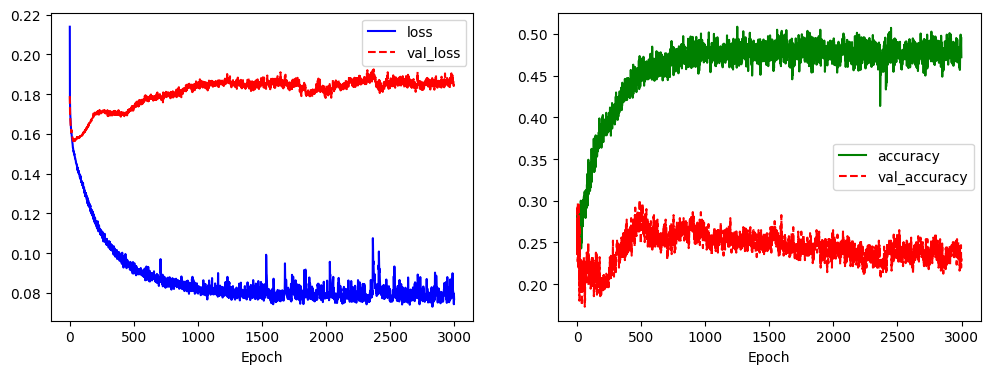

[0.1900017410516739, 0.26224783062934875]

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-', label = 'loss')
plt.plot(history.history['val_loss'], 'r--', label = 'val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'g-', label = 'accuracy')
plt.plot(history.history['val_accuracy'], 'r--', label = 'val_accuracy')
plt.xlabel('Epoch')
# plt.ylim(0, 0.6)
plt.legend()

plt.show()

model.evaluate(x_test, y_test, verbose = 0)

In [ ]:
model.evaluate(x_test, y_test)
model.save('Data/output/lstm001_epoch3000')
model.save('Data/output/lstm001_epoch3000.h5')

In [ ]:
prediction = model.predict(transform_sequential_dataset(MFCCs_T, 32))
print(prediction)

In [ ]:
def count_ratio(temp) :
  count = 0
  for i in range(len(temp)) :
    for j in range(len(temp[0])) :
      if temp[i][j] > 0.99 :
        count += 1
  ratio = count / (len(temp) * 4)
  print(count, ratio)
  return 0

In [ ]:
count_ratio(prediction)
count_ratio(noteinfo_np)

3226 0.23255478662053056
3267 0.23551038062283736


0

In [ ]:
answer = [[0] * button_count for i in range(round(music_length_sec / note_time_dist) + 1)]
for i in range(len(prediction)) :
  for j in range(len(prediction[0])) :
    if prediction[i][j] > 0.99 :
      answer[i][j] = 1

In [ ]:
notemap = open('Data/output/lstm001_notemap.txt', 'w+')
noteinfo = open('Data/output/lstm001_noteinfo.txt', 'w+')

for i in range(len(answer)) :
  if i > 0 :
    notemap.write(str(i * 75 - 15) + ',')
    for j in range(len(answer[0])) :
      if j == 3 :
        notemap_line = str(answer[i][j]) + '\n'
      else :
        notemap_line = str(answer[i][j]) + ','
      notemap.write(notemap_line)
      if answer[i][j] == 1 :
        noteinfo_line = str(i * 75 - 15) + ',' + str(j) + '\n'
        noteinfo.write(noteinfo_line)

notemap.close()
noteinfo.close()